# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "/Users/pratheerthpadman/Desktop/traffic-signs-data/train.p"
validation_file = "/Users/pratheerthpadman/Desktop/traffic-signs-data/valid.p"
testing_file = "/Users/pratheerthpadman/Desktop/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**
 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [52]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np
import pandas as pd

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

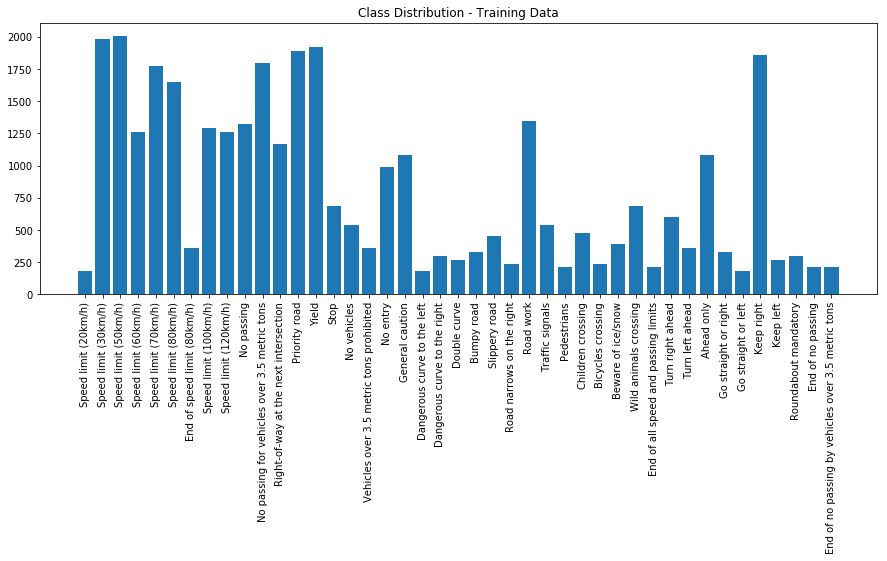

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(15,5))

signs = pd.read_csv("signnames.csv")
sign_label = signs["SignName"]

label_list = [label for label in sign_label]

# Class frequency distribution for training data
unique_train, count_train = np.unique(y_train, return_counts=True)
plt.bar(unique_train, count_train)

plt.title("Class Distribution - Training Data")
plt.xticks(np.arange(y_train.min(), y_train.max()+1), label_list, rotation=90)
plt.show()

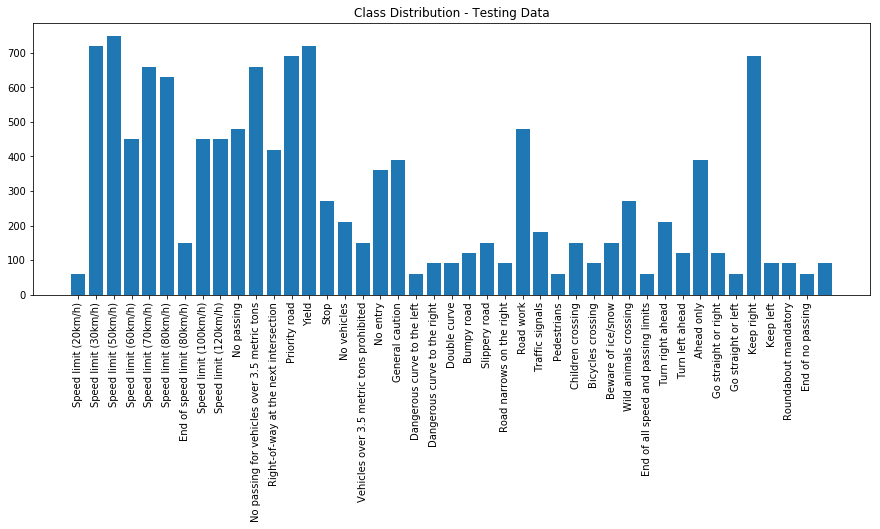

In [4]:
# Class frequency distribution of training data
fig = plt.figure(figsize=(15,5))

unique_test, count_test = np.unique(y_test, return_counts=True)
plt.bar(unique_test, count_test)

plt.title("Class Distribution - Testing Data")
plt.xticks(np.arange(y_test.min(), y_test.max()), label_list, rotation=90)
plt.show()

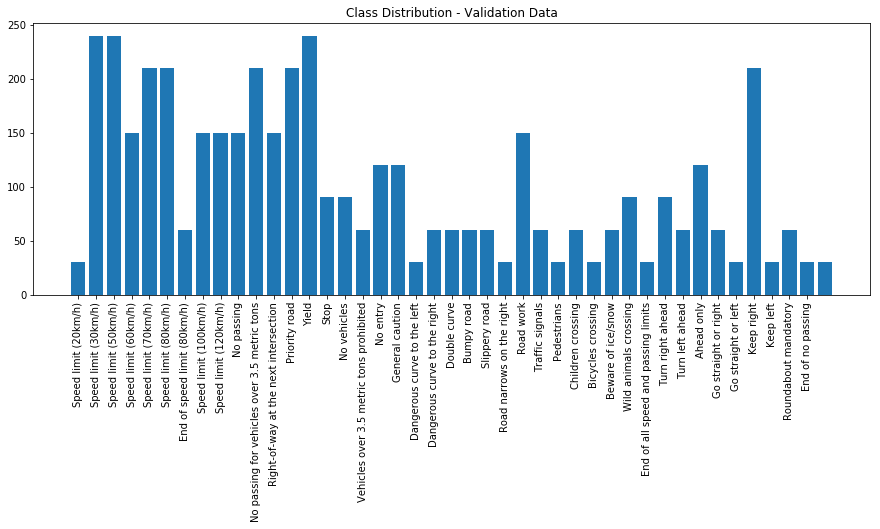

In [5]:
# Class frequency distribution for the validation set
fig = plt.figure(figsize=(15,5))

unique_valid, count_valid = np.unique(y_valid, return_counts=True)
plt.bar(unique_valid, count_valid)

plt.title("Class Distribution - Validation Data")
plt.xticks(np.arange(y_valid.min(), y_valid.max()), label_list, rotation=90)
plt.show()

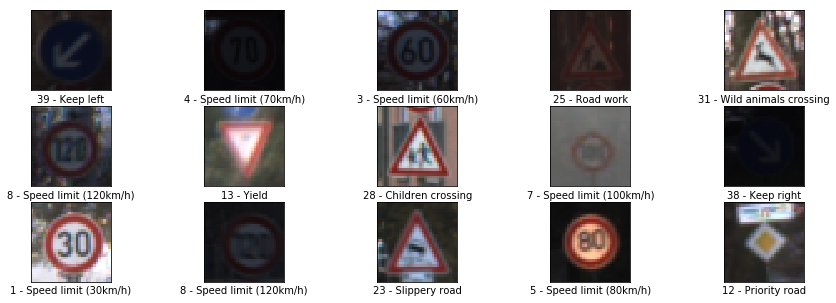

In [6]:
# Plotting traffic sign images

images = np.random.randint(1, len(X_train), 15)

fig = plt.figure(figsize=(15,5))
for ix, val in enumerate(images):
    img = fig.add_subplot(3, 5, ix+1)
    plt.imshow(X_train[val-1])
    
    # Add corresponding labels
    img.set_xlabel("{} - {}".format(y_train[val-1], label_list[y_train[val-1]]))
    # Remove axis ticks
    img.set_xticks([])
    img.set_yticks([])
    
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

In [7]:
# Data Augmentation
import cv2

def transform_image(img, ang_range, shear_range, trans_range):
    
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    height, width, ch = img.shape
    rot_M = cv2.getRotationMatrix2D((width/2, height/2), ang_rot, 1)
    
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    trans_M = np.float32([[1,0,tr_x], [0,1,tr_y]])
    
    # Shear
    pts1 = np.float32([[5,5], [20,5], [5,20]])
    
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,rot_M,(width,height))
    img = cv2.warpAffine(img,trans_M,(width, height))
    img = cv2.warpAffine(img,shear_M,(width, height))
    
    return img
    

In [8]:
def data_augmentation(X_data):
    
    aug_image = []
    for ix, img in enumerate(X_data):
        aug_image.append(transform_image(img, 30, 3, 3))
    
    X_train_aug = np.array(aug_image)
    
    return X_train_aug

In [9]:
X_train1 = data_augmentation(X_train)

In [10]:
X_aug_train = np.concatenate((X_train, X_train1), axis=0).astype(np.float32)
y_aug_train = np.concatenate((y_train, y_train), axis=0)

### Pre-process the Data Set (normalization, grayscale, etc.)

In [12]:
def grayscale(X_data):
    # Conversion to grayscale
    
    X_gray = [cv2.cvtColor(X, cv2.COLOR_BGR2GRAY) for X in X_data]
    return X_gray
    
X_gray_train = grayscale(X_aug_train)
X_gray_test = grayscale(X_test)
X_gray_valid = grayscale(X_valid)

In [13]:
def normalize(X_data):
    return [(X/122.5) - 1 for X in X_data]

X_normgray_train = normalize(X_gray_train)
X_normgray_test = normalize(X_gray_test)
X_normgray_valid = normalize(X_gray_valid)

In [14]:
X_normgray_train = np.reshape(X_normgray_train, (-1, 32, 32, 1)).astype(np.float32)
X_normgray_test = np.reshape(X_normgray_test, (-1, 32, 32, 1)).astype(np.float32)
X_normgray_valid = np.reshape(X_normgray_valid, (-1, 32, 32, 1)).astype(np.float32)

### Model Architecture

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

epochs = 30
batch_size = 256

# LeNet Architecture
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):
    # Hyperparameters for normal distribution
    mu = 0
    sigma = 0.1
    
    # Layer 1. Input - 32x32x1. Output 28x28x6
    conv1_w = tf.Variable(tf.truncated_normal(shape =(5, 5, 1, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding="VALID") + conv1_b

    # Activation - ReLU
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input - 28x28x6. Output - 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    
    # Conv2. Output - 10x10x16
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding="VALID") + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    # Pooling. Input - 10x10x16. Output - 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    
    # Flatten. Input - 5x5x16. Output - 400
    fc0 = flatten(conv2)
    
    # FC1. Input - 400. output - 120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # FC2. Input - 120. Output - 84
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    fc2 - tf.nn.dropout(fc2, keep_prob)
    
    # FC3. Input - 84. Output - 43
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

### Features and Labels

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) #probability to keep units
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Training Pipeline
rate = 0.001
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [20]:
# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

training_loss_history = []
validation_loss_history = []
def evaluate(X_data, y_data, keep_prob_val):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        loss, accuracy = sess.run([loss_operation, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_val})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples


In [21]:
# Training the model
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_normgray_train)
    
    print("Training....")
    print()
    for i in range(epochs):
        X_normgray_train, y_aug_train = shuffle(X_normgray_train, y_aug_train)
        for offset in range(0, num_examples, batch_size):
            end = offset+batch_size
            batch_x, batch_y = X_normgray_train[offset:end], y_aug_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
        
        train_loss, train_accuracy = evaluate(X_normgray_train, y_aug_train, 1.0)
        training_loss_history.append(train_loss)
        validation_loss, validation_accuracy = evaluate(X_normgray_valid, y_valid, 1.0)
        validation_loss_history.append(validation_loss)
        
        print("EPOCH {}".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print("Training Loss = {:.3f}".format(train_loss))
        print()
        
        try:
            saver
        except NameError:
            saver = tf.train.Saver()
        saver.save(sess, "my_model")
        print("Model Saved")


Training....

EPOCH 1
Validation Accuracy = 0.736
Validation Loss = 1.143
Training Loss = 1.267

Model Saved
EPOCH 2
Validation Accuracy = 0.821
Validation Loss = 0.676
Training Loss = 0.729

Model Saved
EPOCH 3
Validation Accuracy = 0.865
Validation Loss = 0.529
Training Loss = 0.550

Model Saved
EPOCH 4
Validation Accuracy = 0.870
Validation Loss = 0.456
Training Loss = 0.466

Model Saved
EPOCH 5
Validation Accuracy = 0.910
Validation Loss = 0.377
Training Loss = 0.365

Model Saved
EPOCH 6
Validation Accuracy = 0.906
Validation Loss = 0.338
Training Loss = 0.302

Model Saved
EPOCH 7
Validation Accuracy = 0.914
Validation Loss = 0.319
Training Loss = 0.289

Model Saved
EPOCH 8
Validation Accuracy = 0.923
Validation Loss = 0.287
Training Loss = 0.252

Model Saved
EPOCH 9
Validation Accuracy = 0.940
Validation Loss = 0.242
Training Loss = 0.210

Model Saved
EPOCH 10
Validation Accuracy = 0.927
Validation Loss = 0.263
Training Loss = 0.200

Model Saved
EPOCH 11
Validation Accuracy = 0.93

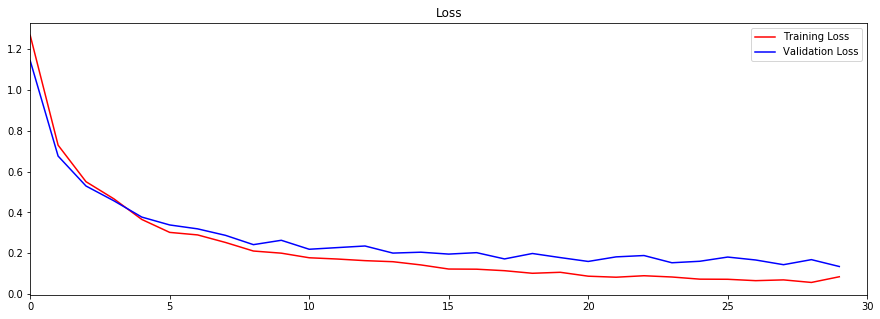

In [22]:
fig = plt.figure(figsize=(15,5))
plt.title("Loss")
plt.plot(training_loss_history, "r", label="Training Loss")
plt.plot(validation_loss_history, "b", label="Validation Loss")
plt.xlim([0, epochs])
plt.legend(loc=1)

In [23]:
# Testing the model

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my_model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    print("Model Restored")
    test_loss, test_accuracy = evaluate(X_normgray_test, y_test, 1.0)

print("Test Accuracy = {:.3f}".format(test_accuracy))

Model Restored
Test Accuracy = 0.932


---

## Step 3: Test a Model on New Images


### Load and Output the Images

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os


images = os.listdir("new_images/")[1:]
images.sort()

new_images = []

for ix, val in enumerate(images):
    #read in an image
    image = cv2.imread("new_images/" + images[ix])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if image.shape[0] != 32:
        image = cv2.resize(image, (32,32))
    
    new_images.append(image)



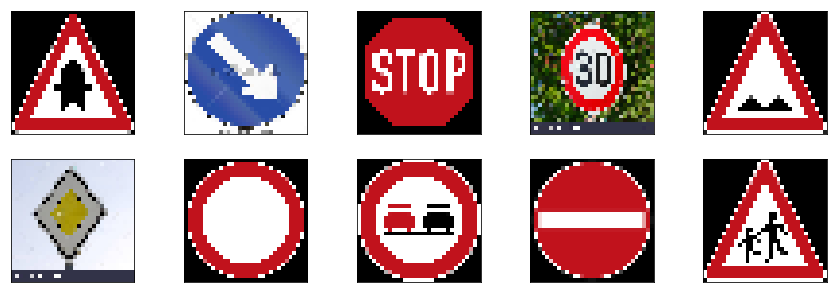

In [25]:
# Plotting the images

fig = plt.figure(figsize=(15, 5))

for i in range(1, len(new_images)+1):
    img = fig.add_subplot(2, 5, i)
    plt.imshow(new_images[i-1])
    img.set_xticks([])
    img.set_yticks([])
    
plt.show()

In [26]:
# Grayscaling
new_images_gray = grayscale(new_images)

In [27]:
# Normalize

new_normgray = normalize(new_images_gray)

In [28]:
new_normgray = np.reshape(new_normgray, (-1, 32, 32, 1)).astype(np.float32)

In [29]:
new_normgray.shape

(10, 32, 32, 1)

### Predict the Sign Type for Each Image

In [30]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Specify ground truth labels
y_newimages = np.array([11, 38, 14, 1, 22, 12, 15, 9, 17, 28])

prediction = tf.argmax(logits, axis=1)

In [31]:
# Run Model
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my_model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    newimage_predictions = sess.run(prediction, feed_dict={x: new_normgray, keep_prob: 1})

In [32]:
newimage_predictions

array([11, 38, 13,  1, 24, 12, 38,  9, 17, 28])

In [33]:
new_normgray.shape

(10, 32, 32, 1)

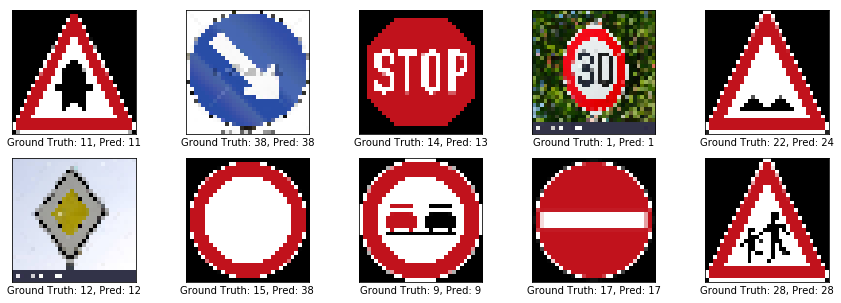

In [34]:
fig = plt.figure(figsize=(15,5))
# Create subplots in figure
for r in range(1,len(new_images)+1):
    img = fig.add_subplot(2,5,r)
    plt.imshow(new_images[r-1])
    img.set_xlabel("Ground Truth: {0}, Pred: {1}".format(y_newimages[r-1],newimage_predictions[r-1]))
    img.set_xticks([])
    img.set_yticks([])

plt.show()

### Analyze Performance

In [35]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
correct_predictions = np.sum(newimage_predictions == y_newimages)
accuracy_newimages = correct_predictions / len(y_newimages)

print ("The prediction accuracy for the 10 new images is: {}%".format(accuracy_newimages*100))

The prediction accuracy for the 10 new images is: 70.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [63]:
prob = tf.nn.softmax(logits)
prob_top5 = tf.nn.top_k(prob, k=5)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('my_model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = sess.run(prob_top5, feed_dict={x: new_normgray, keep_prob: 1.0})

for i, val in enumerate(pred):    
    print(np.round(pred[i], 3))   


[[ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 0.99000001  0.007       0.001       0.001       0.001     ]
 [ 0.833       0.145       0.021       0.          0.        ]
 [ 0.56300002  0.38299999  0.053       0.001       0.        ]
 [ 0.98500001  0.009       0.004       0.001       0.        ]
 [ 0.99599999  0.003       0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]]
[[11 12 30 23 21]
 [38 34 36 23 13]
 [13 36 11 38  3]
 [ 1  2  0  5  7]
 [24 22 29 26 27]
 [12 13 35  3 34]
 [38 15 35 32 12]
 [ 9 12 17 16 41]
 [17 14 34 10 16]
 [28 20 11 36 23]]


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")